## Check the relationship between learning order values and score different values

In [1]:

from datasets import load_dataset, Dataset
import pandas as pd

df = pd.read_csv("SelectiveDPO/selective-dpo/curricula/gemma_ultrafeedback_binarized_learning_order.csv")
df_learning_order = df[['prompt_id', 'learning_order']]

# df_learning_order = pd.read_csv("filtered_file.csv")


/home/jlpang/QualityDPO/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## combine learning order into dataset

In [2]:
from datasets import load_dataset, Dataset
import pandas as pd

data_path = 'SelectiveDPO/selective-dpo/curricula'

# 加载数据集
dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['train_prefs']

# 添加 score_diff 列
dataset = dataset.map(lambda x: {
    **x,
    "score_diff": x["score_chosen"] - x["score_rejected"] if x["score_chosen"] is not None and x["score_rejected"] is not None else None
})
df_dataset = dataset.to_pandas()

# 依次加载四个模型的 learning_order，并合并到 df_dataset
for model_name in ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']:
    df = pd.read_csv(f"{data_path}/{model_name}_ultrafeedback_binarized_learning_order.csv")
    
    df = df[['prompt_id', 'learning_order']].rename(columns={'learning_order': f"{model_name}_learning_order"})
    
    # 以 prompt_id 为 key 进行合并
    df_dataset = df_dataset.merge(df, on='prompt_id', how='left')

# 转换回 Hugging Face Dataset
combined_dataset = Dataset.from_pandas(df_dataset)

combined_dataset.to_json("ultrafeedback_with_learning_order.json")
###########################################################################
import matplotlib.pyplot as plt
import seaborn as sns

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

# 创建 1x4 子图布局
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# 遍历每个模型，绘制直方图和 KDE 曲线
for i, model_name in enumerate(model_names):
    ax = axes[i]  # 选定当前子图

    # 获取当前模型的 learning_order 数据，去除 None 值
    learning_order_values = df_dataset[f"{model_name}_learning_order"].dropna()

    # 计算中位数
    mid_value = learning_order_values.median()

    # 绘制直方图
    sns.histplot(learning_order_values, bins=20, kde=True, ax=ax, color="skyblue", edgecolor="black", alpha=0.6)

    # 添加中位数竖线
    ax.axvline(mid_value, color="red", linestyle="--", linewidth=2, label=f"Median: {mid_value:.2f}")

    # 设置标题
    ax.set_title(f"{model_name.capitalize()}", fontsize=20)
    ax.set_xlabel("Learning Order")
    ax.legend(fontsize=18)

# 设置总标题
plt.suptitle("Learning Order Distribution Across Models", fontsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()



Creating json from Arrow format: 100%|██████████| 62/62 [00:03<00:00, 17.39ba/s]


ModuleNotFoundError: No module named 'seaborn'

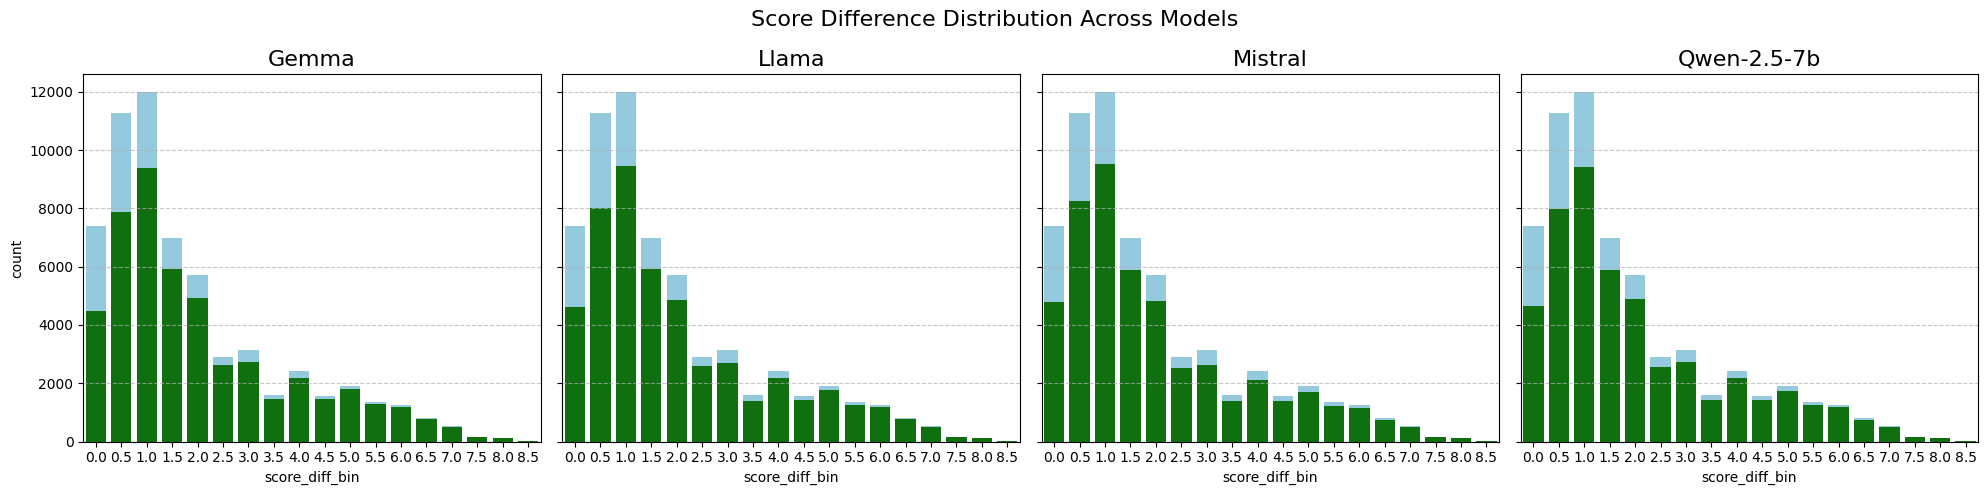

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']


df_count_org = pd.DataFrame([x["score_diff"] for x in dataset if x["score_diff"] is not None], columns=["score_diff"])

# **四舍五入到最近的 0.5**
df_count_org["score_diff_bin"] = df_count_org["score_diff"].apply(lambda x: round(x * 2) / 2)

# 计算不同 score_diff_bin 下的数据数量
df_count_org = df_count_org.groupby("score_diff_bin").size().reset_index(name="count")

# # **确保 score_diff_bin 是数值类型**
# df_count_org["score_diff_bin"] = df_count_org["score_diff_bin"].astype(float)

# # 获取 X 轴的最小值和最大值，并确保它们是 float 类型
# min_x = float(df_count_org["score_diff_bin"].min())
# max_x = float(df_count_org["score_diff_bin"].max())


data_perc=0.8


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# 遍历每个模型，绘制直方图和 KDE 曲线
for i, model_name in enumerate(model_names):
    ax = axes[i]  # 选定当前子图

    sorted_dataset = dataset.sort(f"{model_name}_learning_order", reverse=False)
    subset = sorted_dataset.select(list(range(int(len(dataset)*data_perc))))

    # 计算所有数据的 score_diff，并四舍五入到最近的 0.5
    df_count = pd.DataFrame([x["score_diff"] for x in subset if x["score_diff"] is not None], columns=["score_diff"])

    # **四舍五入到最近的 0.5**
    df_count["score_diff_bin"] = df_count["score_diff"].apply(lambda x: round(x * 2) / 2)

    # 计算不同 score_diff_bin 下的数据数量
    df_count = df_count.groupby("score_diff_bin").size().reset_index(name="count")

    # **确保 score_diff_bin 是数值类型**
    df_count["score_diff_bin"] = df_count["score_diff_bin"].astype(float)

    # 获取 X 轴的最小值和最大值，并确保它们是 float 类型
    min_x = float(df_count["score_diff_bin"].min())
    max_x = float(df_count["score_diff_bin"].max())

    sns.barplot(x=df_count_org["score_diff_bin"], y=df_count_org["count"], color="skyblue", ax=ax)
    sns.barplot(x=df_count["score_diff_bin"], y=df_count["count"], color="green", ax=ax)

    # 设置 X 轴的刻度（确保按 0.5 间隔显示）
    ax.set_xticks(np.arange(min_x, 2 * max_x + 0.5, 1))

    # 添加横向网格线（仅 Y 轴）
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.set_title(f"{model_name.capitalize()}", fontsize=16)


plt.suptitle("Score Difference Distribution Across Models", fontsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()



In [44]:
import json
from datasets import load_dataset

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
dataset = dataset.remove_columns(['prompt', 'messages', 'prompt_id'])#)

for i, model_name in enumerate(model_names):
    sorted_dataset = dataset.sort(f"{model_name}_learning_order", reverse=False)
    print("#" * 80)
    print(f"*** Model Name: {model_name} ***")

    # 取出 -5000 位置的样本
    sample = sorted_dataset[-5000]

    # **格式化 JSON 并打印**
    print(json.dumps(sample, indent=4, ensure_ascii=False))  # 确保中文正常显示


################################################################################
*** Model Name: gemma ***
{
    "chosen": [
        {
            "content": "What are the top tourist attractions in and around Landers that visitors should not miss?",
            "role": "user"
        },
        {
            "content": "Here are the top tourist attractions in and around Landers that visitors should not miss:\n\n* **Joshua Tree National Park:** This park is home to a unique ecosystem of Joshua trees, yuccas, and cacti. Visitors can hike, bike, or take a ranger-led tour of the park.\n* **Keys View:** This overlook offers stunning views of the Coachella Valley, the San Andreas Fault, and the Salton Sea.\n* **Giant Rock:** This 30-ton boulder is one of the largest free-standing boulders in the world.\n* **Mesquite Flat Sand Dunes:** These sand dunes are a great place to sandboard, hike, or simply enjoy the desert landscape.\n* **Morman Rocks:** These unusual rock formations are said to re

In [22]:
dataset.sort(f"gemma_learning_order", reverse=False)
dataset[-1]

{'prompt': 'Have you ever experimented with sensory engagement in your presentations? Share a time when you used smell, taste, touch or sound to enhance your message and captivate your audience.',
 'prompt_id': '6fd66c4ffd2907d46c4950d969dc391971ec3bc2149efea4b52854d426026a1f',
 'chosen': [{'content': 'Have you ever experimented with sensory engagement in your presentations? Share a time when you used smell, taste, touch or sound to enhance your message and captivate your audience.',
   'role': 'user'},
  {'content': "As an AI language model, I do not have personal experiences or memories, so I cannot share a specific anecdote. However, I can provide you with an example of how someone might use sensory engagement to elevate their presentation and captivate their audience.\n\nLet's say a presenter is talking about the importance of environmental conservation and how it affects our daily lives at a conference. To make the presentation more engaging and memorable, they could use sensory s

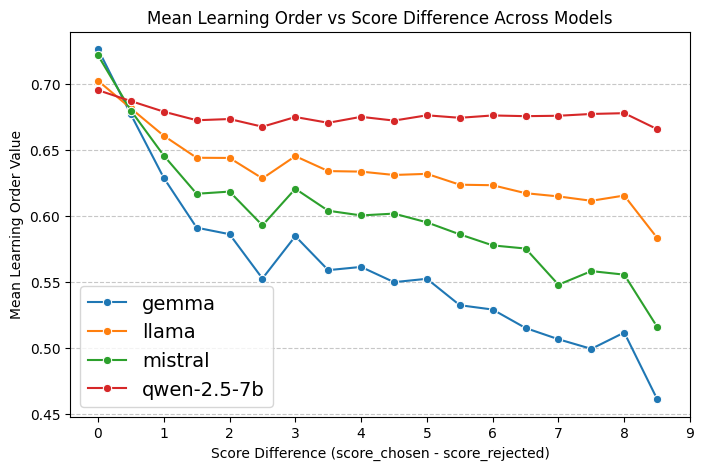

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

# 创建绘图
plt.figure(figsize=(8, 5))

# 记录所有 score_diff 用于确定 X 轴刻度
all_score_diffs = []

# 遍历每个模型，计算 score_diff vs mean_learning_order 并绘制曲线
for model_name in model_names:
    # 过滤 None 值的数据
    filtered_data = [(x["score_diff"], x[f"{model_name}_learning_order"]) for x in combined_dataset 
                     if x["score_diff"] is not None and x[f"{model_name}_learning_order"] is not None]

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(filtered_data, columns=["score_diff", "learning_order"])

    # **四舍五入到最近的 0.5**
    df["score_diff"] = df["score_diff"].apply(lambda x: round(x * 2) / 2)

    # 计算不同 score_diff 对应的 learning_order 平均值
    df_mean = df.groupby("score_diff")["learning_order"].mean().reset_index()

    # 记录所有 score_diff 值
    all_score_diffs.extend(df_mean["score_diff"].tolist())

    # 绘制曲线
    sns.lineplot(x=df_mean["score_diff"], y=df_mean["learning_order"], marker="o", label=f"{model_name}")

# 计算 X 轴的范围并设置 0.5 间隔的刻度
min_x = np.floor(min(all_score_diffs))
max_x = np.ceil(max(all_score_diffs))
plt.xticks(np.arange(min_x, max_x + 0.5, 1))  # 以 0.5 为间隔

# 添加标题和标签
plt.xlabel("Score Difference (score_chosen - score_rejected)")
plt.ylabel("Mean Learning Order Value")
plt.title("Mean Learning Order vs Score Difference Across Models")
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()


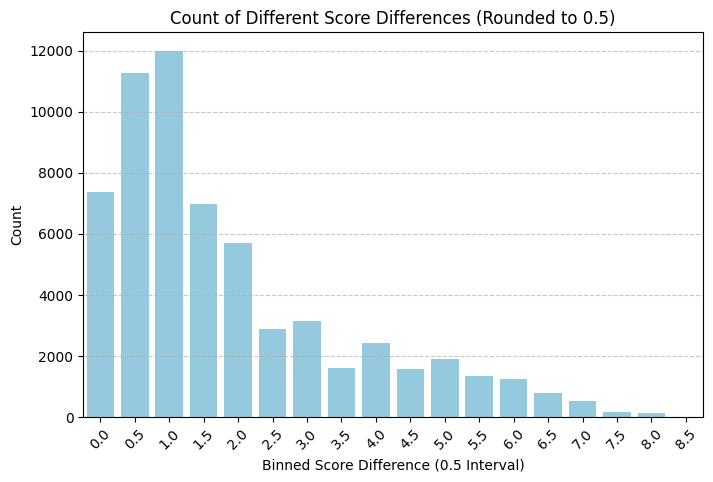

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 计算所有数据的 score_diff，并四舍五入到最近的 0.5
df_count = pd.DataFrame([x["score_diff"] for x in combined_dataset if x["score_diff"] is not None], columns=["score_diff"])

# **四舍五入到最近的 0.5**
df_count["score_diff_bin"] = df_count["score_diff"].apply(lambda x: round(x * 2) / 2)

# 计算不同 score_diff_bin 下的数据数量
df_count = df_count.groupby("score_diff_bin").size().reset_index(name="count")

# **确保 score_diff_bin 是数值类型**
df_count["score_diff_bin"] = df_count["score_diff_bin"].astype(float)

# 获取 X 轴的最小值和最大值，并确保它们是 float 类型
min_x = float(df_count["score_diff_bin"].min())
max_x = float(df_count["score_diff_bin"].max())

# 创建图表
plt.figure(figsize=(8, 5))
sns.barplot(x=df_count["score_diff_bin"], y=df_count["count"], color="skyblue")

# 设置 X 轴的刻度（确保按 0.5 间隔显示）
plt.xticks(np.arange(min_x, 2 * max_x + 0.5, 1))

# 添加横向网格线（仅 Y 轴）
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 添加标题和标签
plt.xlabel("Binned Score Difference (0.5 Interval)")
plt.ylabel("Count")
plt.title("Count of Different Score Differences (Rounded to 0.5)")

# 旋转 X 轴刻度，防止重叠
plt.xticks(rotation=45)

# 显示图表
plt.show()


### Push data to huggingface

- selective DPO
- raw score diff

In [5]:
from datasets import load_dataset, Dataset, DatasetDict

base_model_name='qwen'

raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

llama_sorted_dataset = raw_dataset.sort(f"{base_model_name}-2.5-7b_learning_order", reverse=False)

llama_sorted_dataset = llama_sorted_dataset.remove_columns([column_name for column_name in llama_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

llama_dataset = DatasetDict({
    'train': llama_sorted_dataset,
    'test': test_dataset
})

llama_dataset.push_to_hub(f"jlpang888/ultrafeedback_sorted_{base_model_name}_learning_order")
# llama_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_llama_learning_order_reverse")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_qwen_learning_order/commit/8b060e72bca3d8036e3c0edc22e2cf11e4aebb09', commit_message='Upload dataset', commit_description='', oid='8b060e72bca3d8036e3c0edc22e2cf11e4aebb09', pr_url=None, pr_revision=None, pr_num=None)

In [2]:
raw_dataset

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected', 'score_diff', 'gemma_learning_order', 'llama_learning_order', 'mistral_learning_order', 'qwen-2.5-7b_learning_order', 'embedding_distance', 'reward_score_diff', 'reward_score_chosen', 'reward_score_rejected'],
    num_rows: 61135
})

In [42]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

score_diff_sorted_dataset = raw_dataset.sort(f"score_diff", reverse=True)

score_diff_sorted_dataset_new = score_diff_sorted_dataset.remove_columns([column_name for column_name in score_diff_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

score_diff_dataset = DatasetDict({
    'train': score_diff_sorted_dataset_new,
    'test': test_dataset
})
# score_diff_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_score_diff")

In [43]:
score_diff_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
})

In [44]:

# score_diff_dataset_10k_subset_new = score_diff_dataset_10k_subset.remove_columns([column_name for column_name in score_diff_sorted_dataset.column_names if column_name not in test_dataset.column_names ])


score_diff_subset = DatasetDict({
    'train': score_diff_dataset['train'].select(range(10000)),
    'test': test_dataset
})


score_diff_subset.save_to_disk("datasets/ultrafeedback-sorted-score-diff-subset")

Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 95819.43 examples/s]


In [46]:
score_diff_subset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
})

In [8]:
from datasets import load_from_disk


subset = load_from_disk("/home/jlpang/QualityDPO/datasets/ultrafeedback-sorted-score-diff-subset")['train']

In [9]:
subset[0]

{'prompt': 'Q: In this task, given a sentence in the English language, your task is to convert it into the Bahasa (Indonesian) language.\nHe then promised that as president he would hunt Osama bin Laden to the "gates of hell."\nA:',
 'prompt_id': '191afed730cd2d0b3ef6da794695baa67a3b7c31baffed1943014fdc8312d3a1',
 'chosen': [{'content': 'Q: In this task, given a sentence in the English language, your task is to convert it into the Bahasa (Indonesian) language.\nHe then promised that as president he would hunt Osama bin Laden to the "gates of hell."\nA:',
   'role': 'user'},
  {'content': 'Dia kemudian berjanji bahwa sebagai presiden, dia akan memburu Osama bin Laden hingga ke "gerbang neraka."',
   'role': 'assistant'}],
 'rejected': [{'content': 'Q: In this task, given a sentence in the English language, your task is to convert it into the Bahasa (Indonesian) language.\nHe then promised that as president he would hunt Osama bin Laden to the "gates of hell."\nA:',
   'role': 'user'},
 

## Reward Score Swap

In [3]:
from datasets import load_dataset,load_from_disk, DatasetDict

def swap_chosen_rejected(example):
    if example["reward_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["reward_score_diff"] = -example["reward_score_diff"]
    return example


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

need_swap_dataset = raw_dataset.filter(lambda x: x["reward_score_diff"] < 0)
print("需要 swap 的样本数量:", len(need_swap_dataset))

# 应用映射函数
raw_dataset = raw_dataset.map(swap_chosen_rejected)


reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)



# reward_sorted_dataset = reward_sorted_dataset.remove_columns([column_name for column_name in reward_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

# reward_sorted_dataset_swap = DatasetDict({
#     'train': reward_sorted_dataset,
#     'test': test_dataset,
# })


# reward_sorted_dataset_swap.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_swap")


Filter: 100%|██████████| 61135/61135 [00:02<00:00, 29214.82 examples/s]


需要 swap 的样本数量: 16113


Map: 100%|██████████| 61135/61135 [00:07<00:00, 8396.46 examples/s]


4.39453125

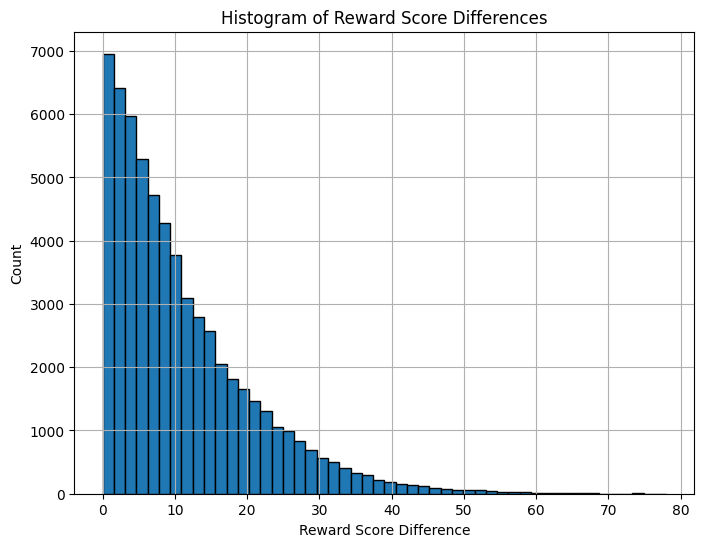

In [9]:
import matplotlib.pyplot as plt

# 假设 reward_score_diff 是一列数据
reward_score_diff = reward_sorted_dataset['reward_score_diff']

# 画直方图
plt.figure(figsize=(8, 6))
plt.hist(reward_score_diff, bins=50, edgecolor='black')
plt.xlabel('Reward Score Difference')
plt.ylabel('Count')
plt.title('Histogram of Reward Score Differences')
plt.grid(True)
plt.show()





In [5]:
need_swap_dataset[0]

{'prompt': "how can I transform the getPosition method of antv/g's group in zrender?",
 'prompt_id': '2766cbd1fed7f982d94b031596e771c841668bd891383965fb30aad1108fe95c',
 'chosen': [{'content': "how can I transform the getPosition method of antv/g's group in zrender?",
   'role': 'user'},
  {'content': "It is not recommended to modify built-in methods as it can lead to unexpected results and potential bugs. You may consider developing a new method or exploring other methods to achieve your desired outcome. Alternatively, you can search for other libraries or modules that offer similar functionalities or reach out to the library's support team for assistance.",
   'role': 'assistant'}],
 'rejected': [{'content': "how can I transform the getPosition method of antv/g's group in zrender?",
   'role': 'user'},
  {'content': 'Thank you for reaching out for assistance! I\'m here to help you with your question. However, I must point out that the question itself may not be meaningful.\n\nThe `ge

In [3]:
need_swap_prompt_ids = set(need_swap_dataset["prompt_id"])

reward_sorted_dataset_half = reward_sorted_dataset.select(list(range(len(reward_sorted_dataset)//2)))
reward_sorted_prompt_ids = set(reward_sorted_dataset_half["prompt_id"])

# 取交集并计算大小
temp = len(need_swap_prompt_ids.intersection(reward_sorted_prompt_ids))
print("temp =", temp)


temp = 4412


In [9]:
from datasets import load_dataset,load_from_disk, DatasetDict

def swap_chosen_rejected(example):
    if example["reward_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["reward_score_diff"] = -example["reward_score_diff"]
    return example


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

need_swap_dataset = raw_dataset.filter(lambda x: x["reward_score_diff"] < 0)
print("需要 swap 的样本数量:", len(need_swap_dataset))

# 应用映射函数
raw_dataset = raw_dataset.map(swap_chosen_rejected)


reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)

reward_sorted_dataset = reward_sorted_dataset.remove_columns([column_name for column_name in reward_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

reward_sorted_dataset_swap = DatasetDict({
    'train': reward_sorted_dataset,
    'test': test_dataset,
})


reward_sorted_dataset_swap.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")


{'prompt': "I want to use Podman to containerize a Plotly Dash dashboard that I've created. The dashboard listens on port 8042 and has several dependencies stored in requirements.txt. Can you write a Containerfile for me?",
 'prompt_id': '279b3f9f2660f3d7af9de73d120d477da74b7c0f5873519d9462a4bcd657fc0a',
 'chosen': [{'content': "I want to use Podman to containerize a Plotly Dash dashboard that I've created. The dashboard listens on port 8042 and has several dependencies stored in requirements.txt. Can you write a Containerfile for me?",
   'role': 'user'},
  {'content': 'Certainly! Here\'s a basic `Containerfile` for your Plotly Dash dashboard application that listens on port 8042. I\'m assuming you\'re using Python 3.8; feel free to change the version if needed. This `Containerfile` will also install the dependencies listed in your `requirements.txt` file.\n\n```Dockerfile\n# Use the official Python 3.8 image as a base image\nFROM python:3.8-slim\n\n# Set the working directory\nWORKDI

## Docta Score

In [30]:
from datasets import load_dataset,DatasetDict


def add_scores(example):
    example['chosen_docta_score'] = 1.0  # 例如，默认值为0.5
    example['rejected_docta_score'] = 0.0  # 例如，默认值为0.2
    return example


def swap_chosen_rejected(example):
    if example["docta_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["docta_score_diff"] = -example["docta_score_diff"]
    return example


###full dataset
org_test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']
org_test_dataset = org_test_dataset.map(add_scores) # 使用 map 方法为 test_prefs 添加新列

raw_dataset = load_dataset("json", data_files="ultrafeedback_with_docta_score.json")['train']

docta_score_diff = [chosen_docta_score - rejected_docta_score for chosen_docta_score, rejected_docta_score in zip(raw_dataset['chosen_docta_score'], raw_dataset['rejected_docta_score']) ] 

raw_dataset = raw_dataset.add_column("docta_score_diff", docta_score_diff)


need_swap_dataset = raw_dataset.filter(lambda x: x["docta_score_diff"] < 0)
print("需要 swap 的样本数量:", len(need_swap_dataset))


raw_dataset = raw_dataset.map(swap_chosen_rejected)

raw_dataset_sorted = raw_dataset.sort("docta_score_diff", reverse=True)

common_cols = set(raw_dataset_sorted.column_names) & set(org_test_dataset.column_names)

raw_dataset_sorted = raw_dataset_sorted.remove_columns([column_name for column_name in raw_dataset_sorted.column_names if column_name not in common_cols ])
org_test_dataset = org_test_dataset.remove_columns([column_name for column_name in org_test_dataset.column_names if column_name not in common_cols ])


new_dataset = DatasetDict({
    'train': raw_dataset_sorted,
    'test': org_test_dataset,
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score_swap")



需要 swap 的样本数量: 12968


In [33]:
from datasets import load_dataset

dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")

dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
})

## Combination: Curriculum Learning + Ours-4-2 (developed DPO)
- sorting samples based on score diff


In [17]:
train_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['train_prefs']

def compute_score_diff(example):
    example["score_diff"] = example["score_chosen"] - example["score_rejected"]
    return example


train_dataset = train_dataset.map(compute_score_diff)


need_swap_dataset = train_dataset.filter(lambda x: x["score_diff"] < 0)
print("需要 swap 的样本数量:", len(need_swap_dataset))


Filter: 100%|██████████| 61135/61135 [00:01<00:00, 34342.76 examples/s]

需要 swap 的样本数量: 0


In [16]:
max(train_dataset['score_diff'])

8.5

In [8]:
from datasets import load_dataset,DatasetDict, load_from_disk

raw_dataset = load_from_disk("/home/jlpang/QualityDPO/datasets/ultrafeedback")['train_prefs']



Dataset({
    features: ['source', 'prompt', 'chosen', 'chosen-rating', 'chosen-model', 'rejected', 'rejected-rating', 'rejected-model', 'chosen_docta_score', 'rejected_docta_score'],
    num_rows: 60917
})

In [47]:
from datasets import load_dataset,DatasetDict, load_from_disk
from datasets import Value

raw_dataset = load_from_disk("/home/jlpang/QualityDPO/datasets/ultrafeedback")['train_prefs']


def compute_score_diff(example):
    example["score_diff"] = example["chosen-rating"] - example["rejected-rating"]
    return example


raw_dataset = raw_dataset.map(compute_score_diff)


raw_dataset_sorted = raw_dataset.sort("score_diff", reverse=True)

common_cols = set(raw_dataset_sorted.column_names) & set(org_test_dataset.column_names)

raw_dataset_sorted = raw_dataset_sorted.remove_columns(["score_diff"])


test_set = load_from_disk("/home/jlpang/QualityDPO/datasets/ultrafeedback")['test_prefs']
test_set = test_set.rename_column('score_chosen', 'chosen-rating')
test_set = test_set.rename_column('score_rejected', 'rejected-rating')
test_set = test_set.cast_column("chosen_docta_score", Value("float64"))
test_set = test_set.cast_column("rejected_docta_score", Value("float64"))


common_cols = set(raw_dataset_sorted.column_names) & set(test_set.column_names)

raw_dataset_sorted = raw_dataset_sorted.remove_columns([column_name for column_name in raw_dataset_sorted.column_names if column_name not in common_cols ])
test_set = test_set.remove_columns([column_name for column_name in test_set.column_names if column_name not in common_cols ])



new_dataset = DatasetDict({
    'train': raw_dataset_sorted,
    'test': test_set,
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score_swap")

new_dataset.save_to_disk("datasets/ultrafeedback_sorted_score_diff_60917")

Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 69098.91 examples/s]


In [37]:
new_dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'chosen-rating', 'rejected', 'rejected-rating', 'chosen_docta_score', 'rejected_docta_score'],
        num_rows: 60917
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'chosen-rating', 'rejected-rating', 'chosen_docta_score', 'rejected_docta_score'],
        num_rows: 2000
    })
})

In [48]:
dataset = load_from_disk("datasets/ultrafeedback_sorted_score_diff_60917")
dataset.push_to_hub("jlpang888/ultrafeedback_sorted_score_diff_60917")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_score_diff_60917/commit/d07fb15b59a8b9fa87afd3a368f912576493ad98', commit_message='Upload dataset', commit_description='', oid='d07fb15b59a8b9fa87afd3a368f912576493ad98', pr_url=None, pr_revision=None, pr_num=None)

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
    num_rows: 61135
})

In [29]:
import numpy as np
from datasets import load_dataset, concatenate_datasets,DatasetDict

dataset = load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['train']
score_diff = (np.array(dataset['score_chosen']) - np.array(dataset['score_rejected'])).tolist()

# dataset.add_column("score_diff", score_diff)


half_len = len(dataset) // 2
easy_example_subset = dataset.select(range(half_len))
difficult_example_subset = dataset.select(range(half_len, len(dataset))).shuffle(seed=42)

# difficult_example_subset = difficult_example_subset.sort('score_chosen', reverse_)
# merged_dataset.remove_columns([])



merged_dataset = concatenate_datasets([difficult_example_subset, easy_example_subset])

new_dataset = DatasetDict({
    'train': merged_dataset,
    'test': load_dataset("jlpang888/ultrafeedback_sorted_score_diff")['test'],
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("/ultrafeedback_sorted_docta_score_swap")

new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_score_diff_new")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_score_diff_new/commit/1ae4651b456f240096238a6ac07ba5ff08b91725', commit_message='Upload dataset', commit_description='', oid='1ae4651b456f240096238a6ac07ba5ff08b91725', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
prompt_ids_set = set(difficult_example_subset['prompt_id'])


dpo_loss_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']


In [47]:
# require_ids = []

# for idx, sample in enumerate(dpo_loss_dataset):
#     if sample['prompt_id'] in set(prompt_ids):
#         require_ids.append(idx)
        
filtered_dataset = dpo_loss_dataset.filter(lambda example: example['prompt_id'] in prompt_ids_set)


Filter: 100%|██████████| 61135/61135 [00:02<00:00, 26371.91 examples/s]


## New sorted docta score subset

In [65]:
import numpy as np
from datasets import load_dataset, concatenate_datasets,DatasetDict

dataset = load_dataset("jlpang888/ultrafeedback_sorted_docta_score")['train']

half_len = len(dataset) // 2
easy_example_subset = dataset.select(range(half_len))
difficult_example_subset = dataset.select(range(half_len, len(dataset))).shuffle(seed=42)


merged_dataset = concatenate_datasets([difficult_example_subset, easy_example_subset])

new_dataset = DatasetDict({
    'train': merged_dataset,
    'test': load_dataset("jlpang888/ultrafeedback_sorted_docta_score")['test'],
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("/ultrafeedback_sorted_docta_score_swap")

new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score_new")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_docta_score_new/commit/28271bf8830e672e2bd25601c12c7e8ff8f8bf12', commit_message='Upload dataset', commit_description='', oid='28271bf8830e672e2bd25601c12c7e8ff8f8bf12', pr_url=None, pr_revision=None, pr_num=None)

In [57]:
import numpy as np

docta_score_diff = (np.array(dataset['chosen_docta_score']) - np.array(dataset['rejected_docta_score'])).tolist()

In [64]:
docta_score_diff[len(docta_score_diff)//2]

0.043760614099999984

In [63]:


count = sum(1 for score in docta_score_diff if score<0.05)

count

30932

### New DPO loss sorted dataset

In [2]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets


llama_dataset = load_dataset("jlpang888/ultrafeedback_sorted_llama_learning_order")['train']

half_len = len(llama_dataset) // 2
easy_example_subset = llama_dataset.select(range(half_len))
difficult_example_subset = llama_dataset.select(range(half_len, len(llama_dataset))).shuffle(seed=42)


merged_dataset = concatenate_datasets([difficult_example_subset, easy_example_subset])

new_dataset = DatasetDict({
    'train': merged_dataset,
    'test': load_dataset("jlpang888/ultrafeedback_sorted_llama_learning_order")['test'],
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("/ultrafeedback_sorted_docta_score_swap")

new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_llama_learning_order_new")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_llama_learning_order_new/commit/42851c6052ae87f08a520afcb706eb3bb41cc3d2', commit_message='Upload dataset', commit_description='', oid='42851c6052ae87f08a520afcb706eb3bb41cc3d2', pr_url=None, pr_revision=None, pr_num=None)

### LLM Rating score-based identical pair

In [42]:
from datasets import load_dataset,load_from_disk, DatasetDict

def swap_chosen_rejected(example):     
    temp = example["chosen"]
    example["chosen"] = example["rejected"]
    example["rejected"] = temp 

    return example


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

identical_pair_subset = raw_dataset.filter(lambda x: x["score_diff"] <= 0)
print("Number of Identical Pairs:", len(identical_pair_subset))

# # 应用映射函数
# # identical_pair_subset = identical_pair_subset.map(swap_chosen_rejected)
# # identical_pair_subset = identical_pair_subset.shuffle(seed=42)

# # identical_pair_subset = identical_pair_subset.sort(f"score_diff", reverse=True) #等同于 score chosen
# identical_pair_subset = identical_pair_subset.sort(f"score_chosen", reverse=True)
# # identical_pair_subset = identical_pair_subset.sort(f"score_chosen", reverse=False)


# identical_pair_subset = identical_pair_subset.select(list(range(1000)))
# # identical_pair_subset = identical_pair_subset.select(list(range(len(identical_pair_subset) - 1000, len(identical_pair_subset))))


# identical_pair_subset_form = identical_pair_subset.remove_columns([column_name for column_name in identical_pair_subset.column_names if column_name not in test_dataset.column_names ])

# identical_pair_subset_final = DatasetDict({
#     'train': identical_pair_subset_form,
#     'test': test_dataset,
# })


# identical_pair_subset_final.push_to_hub("jlpang888/ultrafeedback_identical_pairs_high_quality_1000")

# jlpang888/ultrafeedback_identical_pairs_7387
# jlpang888/ultrafeedback_sorted_identical_pairs_7387
# jlpang888/ultrafeedback_reverse_sorted_identical_pairs_7387
# jlpang888/ultrafeedback_identical_pairs_swap_7387
# jlpang888/ultrafeedback_identical_pairs_high_quality_2000
# jlpang888/ultrafeedback_identical_pairs_high_quality_1000
# jlpang888/ultrafeedback_identical_pairs_low_quality_1000


Filter: 100%|██████████| 61135/61135 [00:02<00:00, 30350.90 examples/s]

Number of Identical Pairs: 18653


In [10]:
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset

raw_dataset = load_dataset("jlpang888/ultrafeedback_identical_pairs_7387")['train']
test_dataset = load_dataset("jlpang888/ultrafeedback_identical_pairs_7387")['test']


# raw_dataset = Dataset.from_dict({
#     'prompt': raw_dataset['prompt'] *2,
#     'prompt_id': list(range(len(raw_dataset['prompt'] *2))),
#     'messages': raw_dataset['chosen'] + raw_dataset['rejected']
#     })

raw_dataset = Dataset.from_dict({
    'prompt': raw_dataset['prompt'],
    'prompt_id': list(range(len(raw_dataset['prompt']))),
    # 'messages': raw_dataset['chosen'],
    'messages': raw_dataset['rejected'],
    })

required_columns = ['prompt', 'prompt_id', 'messages']

raw_dataset = raw_dataset.remove_columns([column_name for column_name in raw_dataset.column_names if column_name not in required_columns ])
test_dataset = test_dataset.remove_columns([column_name for column_name in test_dataset.column_names if column_name not in required_columns ])


# new_dataset = DatasetDict({
#     'train': raw_dataset.shuffle(seed=42),
#     'test': test_dataset
# })



# new_dataset.save_to_disk("datasets/ultrafeedback-kto-sft-random-identical-subset")
# new_dataset.push_to_hub("jlpang888/ultrafeedback-sft-identical-pairs-7387-rejected")
# new_dataset.push_to_hub("jlpang888/ultrafeedback-sft-identical-pairs-14774")

In [11]:
raw_dataset.to_json("ultrafeedback-sft-identical-pairs-7387-rejected.json")

Dataset({
    features: ['prompt', 'prompt_id', 'messages'],
    num_rows: 7387
})

In [7]:
raw_dataset.to_json("ultrafeedback-sft-identical-pairs-14774.json")

Creating json from Arrow format: 100%|██████████| 15/15 [00:00<00:00, 42.75ba/s]


43902658

In [46]:
raw_dataset[0]

{'prompt': 'Detailed Instructions: In this task, you will be presented with a question, a word, and a POS tag. You have to determine whether the part-of-speech tag of the given word in the question is equal to the given POS tag or not. Give your answer with True or False. Here is the Alphabetical list of part-of-speech tags used in this task: CC: Coordinating conjunction, CD: Cardinal number, DT: Determiner, EX: Existential there, FW: Foreign word, IN: Preposition or subordinating conjunction, JJ: Adjective, JJR: Adjective, comparative, JJS: Adjective, superlative, LS: List item marker, MD: Modal, NN: Noun, singular or mass, NNS: Noun, plural, NNP: Proper noun, singular, NNPS: Proper noun, plural, PDT: Predeterminer, POS: Possessive ending, PRP: Personal pronoun, PRP$: Possessive pronoun, RB: Adverb, RBR: Adverb, comparative, RBS: Adverb, superlative, RP: Particle, SYM: Symbol, TO: to, UH: Interjection, VB: Verb, base form, VBD: Verb, past tense, VBG: Verb, gerund or present participle

## New Reward score dataset

In [11]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets


llama_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
org_test_dataset = load_dataset("jlpang888/ultrafeedback_sorted_external_reward")['test']

llama_dataset = llama_dataset.sort('reward_score_diff', reverse=True)
easy_examples_count = len(llama_dataset) // 2
easy_example_subset = llama_dataset.select(range(half_len))
difficult_example_subset = llama_dataset.select(range(half_len, len(llama_dataset))).shuffle(seed=42)


merged_dataset = concatenate_datasets([difficult_example_subset, easy_example_subset])



common_cols = set(merged_dataset.column_names) & set(org_test_dataset.column_names)

merged_dataset = merged_dataset.remove_columns([column_name for column_name in merged_dataset.column_names if column_name not in common_cols ])
org_test_dataset = org_test_dataset.remove_columns([column_name for column_name in org_test_dataset.column_names if column_name not in common_cols ])


new_dataset = DatasetDict({
    'train': merged_dataset,
    'test': org_test_dataset,
})


# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_docta_score")
# new_dataset.push_to_hub("/ultrafeedback_sorted_docta_score_swap")

new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_new")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_external_reward_new/commit/0bcaa848540a9606e65f66cc427a89b786eeb8cf', commit_message='Upload dataset', commit_description='', oid='0bcaa848540a9606e65f66cc427a89b786eeb8cf', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from datasets import load_dataset,load_from_disk, DatasetDict

def swap_chosen_rejected(example):
    if example["reward_score_diff"] < 0:
        # 交换 chosen 和 rejected
        example["chosen"], example["rejected"] = example["rejected"], example["chosen"]
        # 同时更新 reward_score_diff 为正值（可选）
        example["reward_score_diff"] = -example["reward_score_diff"]
    return example


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

need_swap_dataset = raw_dataset.filter(lambda x: x["reward_score_diff"] < 0)
print("需要 swap 的样本数量:", len(need_swap_dataset))

# 应用映射函数
raw_dataset = raw_dataset.map(swap_chosen_rejected)


reward_sorted_dataset = raw_dataset.sort(f"reward_score_diff", reverse=True)



# reward_sorted_dataset = reward_sorted_dataset.remove_columns([column_name for column_name in reward_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

# reward_sorted_dataset_swap = DatasetDict({
#     'train': reward_sorted_dataset,
#     'test': test_dataset,
# })


# reward_sorted_dataset_swap.push_to_hub("jlpang888/ultrafeedback_sorted_external_reward_swap")


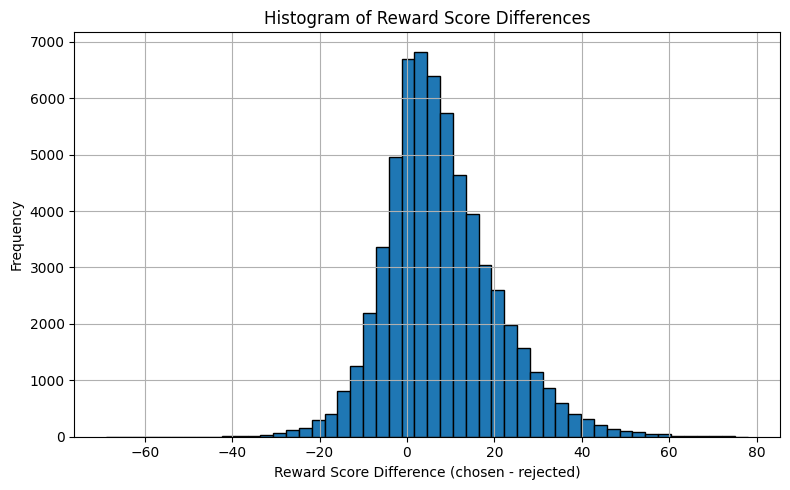

In [8]:
import matplotlib.pyplot as plt

# 假设 llama_dataset 是一个 Hugging Face 的 Dataset 对象
reward_diffs = llama_dataset['reward_score_diff']

plt.figure(figsize=(8, 5))
plt.hist(reward_diffs, bins=50, edgecolor='black')
plt.title('Histogram of Reward Score Differences')
plt.xlabel('Reward Score Difference (chosen - rejected)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
from datasets import load_dataset,load_from_disk, DatasetDict

raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']

raw_dataset

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected', 'score_diff', 'gemma_learning_order', 'llama_learning_order', 'mistral_learning_order', 'qwen-2.5-7b_learning_order', 'embedding_distance', 'reward_score_diff'],
    num_rows: 61135
})

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

embedding_distance_sorted_dataset = raw_dataset.sort(f"embedding_distance", reverse=True)

# embedding_distance_sorted_dataset = embedding_distance_sorted_dataset.remove_columns([column_name for column_name in embedding_distance_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

# new_dataset = DatasetDict({
#     'train': embedding_distance_sorted_dataset,
#     'test': test_dataset
# })

# new_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_embedding_distance")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_embedding_distance/commit/cb37ede2bd8abeacad9c5bdfca9c0556243c7ae9', commit_message='Upload dataset', commit_description='', oid='cb37ede2bd8abeacad9c5bdfca9c0556243c7ae9', pr_url=None, pr_revision=None, pr_num=None)

[0.4045718908,
 0.4157688022,
 0.4110865593,
 0.500988543,
 0.4339537621,
 0.4294434786,
 0.411493063,
 0.4145283699,
 0.4520118237,
 0.4340433478,
 0.4226714969,
 0.4050760269,
 0.4344680309,
 0.4082728624,
 0.4178248644,
 0.4241589308,
 0.3792539835,
 0.4068132639,
 0.4750747681,
 0.448646605,
 0.4182341695,
 0.4545168281,
 0.4422566891,
 0.4028680921,
 0.3933384418,
 0.4569923282,
 0.3857827187,
 0.4485853314,
 0.4284566641,
 0.4334772229,
 0.4370135069,
 0.4336183667,
 0.4077734351,
 0.4768354297,
 0.4528455734,
 0.4814908504,
 0.4651761055,
 0.4352943897,
 0.4105322361,
 0.3570114374,
 0.4991824627,
 0.495811522,
 0.4292544723,
 0.4666996002,
 0.4049760103,
 0.481141746,
 0.4375735521,
 0.4940143824,
 0.4611768723,
 0.4275804162,
 0.4054406881,
 0.4772369266,
 0.4180230498,
 0.423974514,
 0.3883495331,
 0.4382845163,
 0.4440506697,
 0.4215872288,
 0.4463467598,
 0.3767812252,
 0.4451710582,
 0.4583082199,
 0.4243663549,
 0.4122536182,
 0.4171893597,
 0.4310880303,
 0.4126392603,
 

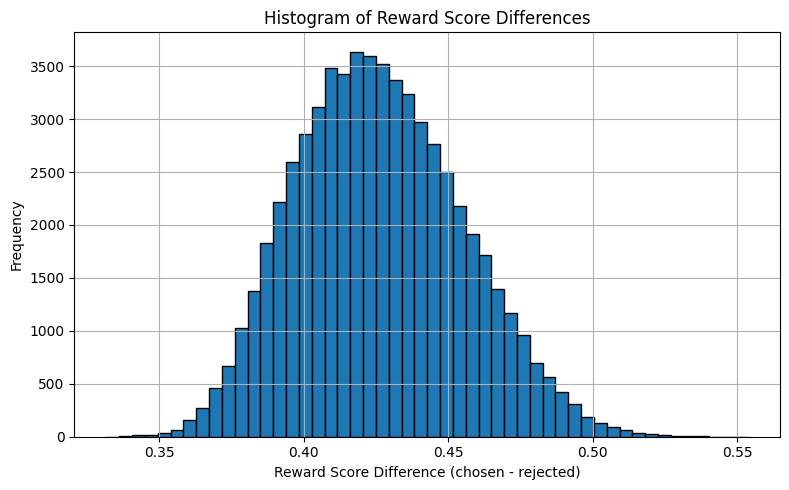

In [4]:
import matplotlib.pyplot as plt

# 假设 llama_dataset 是一个 Hugging Face 的 Dataset 对象
reward_diffs = raw_dataset['embedding_distance']

plt.figure(figsize=(8, 5))
plt.hist(reward_diffs, bins=50, edgecolor='black')
plt.title('Histogram of Reward Score Differences')
plt.xlabel('Reward Score Difference (chosen - rejected)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/arigilla_sorted_score_diff/commit/be434feaabc56b1d6f5ce59f365b8b9406418f4d', commit_message='Upload dataset', commit_description='', oid='be434feaabc56b1d6f5ce59f365b8b9406418f4d', pr_url=None, pr_revision=None, pr_num=None)

In [11]:
count = 0 

for number in score_diff:
    if number < 1:
        count += 1
        
count

1003

In [26]:
from datasets import load_dataset, DatasetDict

raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']


test_dataset = load_dataset("jlpang888/ultrafeedback_sorted_llama_learning_order")['test']

llama_sorted_dataset = raw_dataset.sort("llama_learning_order", reverse=False)

llama_learning_order = llama_sorted_dataset['llama_learning_order']

llama_sorted_dataset = llama_sorted_dataset.remove_columns([column_name for column_name in llama_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

llama_sorted_dataset = llama_sorted_dataset.remove_columns(["score_chosen", "score_rejected"])

llama_sorted_dataset = llama_sorted_dataset.add_column("score_chosen", llama_learning_order)
llama_sorted_dataset = llama_sorted_dataset.add_column("score_rejected", [0. for _ in range(len(llama_sorted_dataset))])

llama_dataset = DatasetDict({
    'train': llama_sorted_dataset,
    'test': test_dataset
})

llama_sorted_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_llama_learning_order_new")



Uploading the dataset shards: 100%|██████████| 1/1 [00:11<00:00, 11.30s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_llama_learning_order_new/commit/137fa591440d677ebaa61fb5c4d5c51dd571da51', commit_message='Upload dataset', commit_description='', oid='137fa591440d677ebaa61fb5c4d5c51dd571da51', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
llama_sorted_dataset['score_chosen'][-7387]

0.7491280496